# Repérage des zones propices à la mise en place d'un réseau de chaleur urbain

***Auteur : Nicolas Matte, étudiant ingénieur à l'école des Mines, 2023-4***

In [1]:
# Imports

from shapely.geometry import shape
import fiona
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Dans ce notebook, nous nous plaçons du point de vue d'une municipalité qui souhaite installer un réseau de chaleur sur son territoire. La première question à laquelle elle souhaite répondre est la suivante : quelle zone géographique est la plus propice à l'établissement d'une telle infrastructure ? Ce document présente une méthode afin d'y répondre.

## Extraction des données géographiques et énergétiques de la commune

Grâce aux bases de données mises en place par les services publics, nous pouvons facilement extraire sur Python les données évoquées dans le titre pour tous les bâtiments de la ville, ainsi que la structure des routes. Les bases de données utilisées sont les suivantes :
* BDNB : données des bâtiments
* BDCARTO : données des routes et délimitation des communes  

Nous prendrons dans ce notebook l'exemple de la ville de Brétigny-sur-Orge (Essonne).

In [2]:
buildings_file = "data/bretigny_sur_orge.gpkg"
roads_file = "data/roads_bretigny.gpkg"

Ces fichiers `gpkg` ont été obtenus en utilisant l'outil `Intersection` du logiciel QGIS.  

La prochaine étape est de les extraire dans des listes python. On a choisi de n'extraire que les bâtiments manipulables dans la suite, c'est-à-dire ceux ne présentant pas l'une des propriétés suivantes :
* La surface n'est pas renseignée;
* La valeur moyenne du DPE n'est pas renseignée;
* L'année de construction n'est pas renseignée;
* La hauteur du bâtiment est inférieure strictement à 3 mètres.

In [3]:
# Extraction des routes
roads_fiona = fiona.open(roads_file)

roads = []

for road in roads_fiona:
    roads.append(road)

nb_roads = len(roads)
roads_fiona.close()

# Extraction des bâtiments
buildings_fiona = fiona.open(buildings_file)

buildings = [] # bâtiments qui seront considérés pour le RCU

for building in buildings_fiona:
    properties = building["properties"]
    if (properties["s_geom_groupe"] is not None) and (properties["dpe_conso_ener_mean"] is not None) and (properties["ffo_bat_annee_construction"] is not None) and (properties["bdtopo_bat_hauteur_mean"] >= 3): 
        buildings.append(building)

buildings_fiona.close()

print(len(buildings), "batiments ont été retenus.")

793 batiments ont été retenus.


Types de bâtiments présents dans la commune :

In [4]:
buildings_types = []
for building in buildings:
    properties = building["properties"]
    type_ = properties["ffo_bat_usage_niveau_1_txt"]
    buildings_types.append(type_)

np.unique(buildings_types)

array(['Ecole', 'Résidentiel collectif', 'Résidentiel individuel',
       'Tertiaire & Autres'], dtype='<U22')

## Première observation : répartition de tous les bâtiments et du réseau routier

Maintenant que les données ont été extraites, nous pouvons dans un premier temps grâce à matplotlib visualiser la répartition des bâtiments retenus dans la commune ainsi que le réseau routier qui sera le support d'installation des tuyaux.

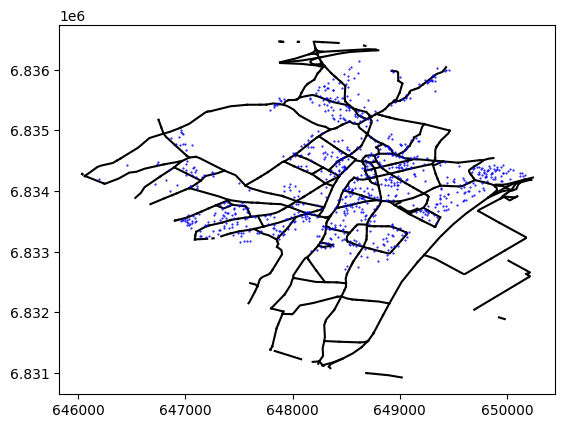

In [5]:
# Tracé des routes et positionnement des noeuds de route
for road in roads:
    # Tracé des routes
    x_ligne1, y_ligne1 = zip(*road["geometry"]["coordinates"][0])
    plt.plot(x_ligne1, y_ligne1, color="black")

# Représentation des bâtiments par des points
for building in buildings:
    polygon_batiment = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid_x, centroid_y = polygon_batiment.centroid.xy
    plt.plot(centroid_x, centroid_y, 'bo', markersize=0.5)

On observe des zones très denses en bâtiments retenus, cependant il manque une information cruciale : la consommation énergétique des bâtiments.

## Estimation de la consommation énergétique des bâtiments

Grâce à la base de données `bdnb`, nous pouvons estimer la consommation énergétique annuelle moyenne de chaque bâtiment à partir de leurs DPE moyen, surface et hauteur.

$$
Q \approx DPE \times S \times E\left(\frac{h}{h_0}\right)
$$

Où $h_0 = 3m$ et où $E$ est la fonction partie entière, afin d'introduire une estimation du nombre d'étages pour chaque bâtiment.

In [6]:
# Calcul des demandes en chaleur pour tous les bâtiments retenus

h_0 = 3 # mètres, taille d'un étage

nb_buildings = len(buildings)
heat_demands = np.zeros(nb_buildings)

for k, building in enumerate(buildings):
    properties = building["properties"]
    Q = properties["dpe_conso_ener_mean"] * properties["s_geom_groupe"] * int(properties["bdtopo_bat_hauteur_mean"] / h_0)
    heat_demands[k] = Q

# Tri suivant les consommations décroissantes
sorted_index = np.argsort(heat_demands)[::-1]
heat_demands = np.sort(heat_demands)[::-1]
buildings = [buildings[index] for index in sorted_index]

Il est intéressant de visualiser la répartition des demandes en chaleur, faisons-le avec un histogramme.

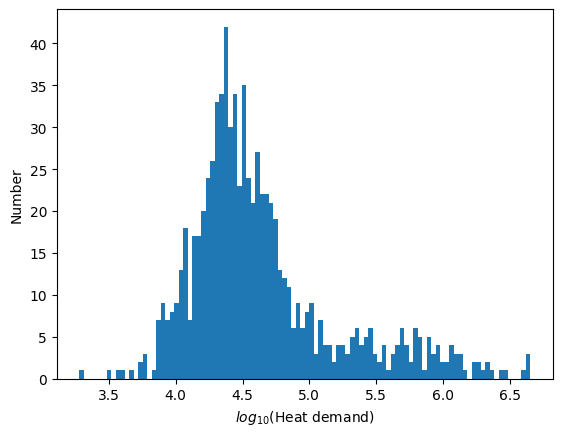

In [7]:
plt.hist(np.log10(heat_demands), bins=100)
plt.xlabel("$log_{10}$(Heat demand)")
plt.ylabel("Number");

Sur une ville entière, les demandes en chaleur par bâtiment sont réparties sur plusieurs ordres de grandeur, d'où l'utilisation du logarithme décimal. On observe une répartition normale du logarithme de la demande en chaleur, avec quelques pics aux très hautes consommations. Nous nous concentrerons sur les bâtiments dont la puissance maximale sur une année excède $30kW$. Pour cela, nous allons définir les courbes de puissance associées à chaque bâtiment.

## Sélection des bâtiments les plus demandeurs

Un critère pour labelliser un réseau de chaleur urbain est de raccorder systématiquement les bâtiments ayant une demande en puissance maximale supérieure à 30kW.

### Courbes des demandes en puissance thermique

Afin de réaliser la simulation d'un réseau de chaleur avec le logiciel Dymola, il faut estimer leurs demandes instantanées tout au long de l'année. Pour cela, nous utilisons la méthode décrite dans les sections suivantes.

#### Utiliser des profils typiques de demande en chaleur

Nous disposons de trois fichiers correspondant aux courbes typiques des bâtiments construits durant les périodes suivantes :
* Avant 1989 (exclu) : `RT_1974_Treated.csv` (il s'agit en réalité des normes des bâtiments construits entre 1974 et 1989);
* Entre 1989 (inclus) et 2005 (exclu) : `RT_1989_Trated.csv` (il s'agit des normes des bâtiments construits entre 1989 et 2005);
* Après 2005 (inclus) : `RT_2005_Treated.csv`.

Il s'agit de timeseries que nous allons manipuler avec `pandas`.

In [8]:
heat_profile_1974 = pd.read_csv("data/RT_1974_Treated.csv", index_col=0)
heat_profile_1989 = pd.read_csv("data/RT_1989_Treated.csv", index_col=0)
heat_profile_2005 = pd.read_csv("data/RT_2005_Treated.csv", index_col=0)

#### Visualisation des données

Il a été vérifié qu'il ne manque aucune donnée dans les timeseries.

In [9]:
heat_profile_1974.head()

,Text,Tindoor,Tdepart,Tretour,Debit_eau,Conso_energetique_integrale
ElapsedTime,,,,,,
0,1.273,17.744,291.691,289.249,0.192,0.064
3600,1.232,17.565,308.755,302.356,0.200,0.894
7200,1.374,19.084,316.640,311.968,0.200,2.493
10800,1.431,19.692,317.198,312.491,0.200,3.868
14400,1.313,19.995,317.443,312.777,0.200,5.269


Pour les trois fichiers, nous disposons des données physiques suivantes par intervalles de temps de $3600s$ :
* $T_{ext}$ est la température de l'air extérieur ($°C$);
* $T_{indoor}$ est la température à l'intérieur du bâtiment ($°C$);
* $T_{depart}$ est la température demandée par le bâtiment, elle correspond à la température de l'eau en début de circuit secondaire, c'est-à-dire juste en aval de l'échangeur de chaleur avec le circuit primaire ($°C$);
* $T_{retour}$ est réciproquement la température de l'eau du circuit secondaire en amont de l'échangeur de chaleur avec le circuit primaire ($°C$);
* $Debit_{eau}$ est le débit massique d'eau du circuit secondaire ($kg.s^{-1}$);
* $Conso \: Energetique \: Integrale$ ne nous intéressera pas.

#### Calcul de la puissance thermique demandée

##### Théorie

Les lois de la thermodynamique conduisent à l'équation suivante :
$$
\Phi_{th} = D_m c_p (T_{départ} - T_{retour})
$$

avec :
* $\Phi_{th}$ la puissance thermique fournie par l'eau à l'air intérieur de l'habitation ($W$);
* $D_m$ le débit massique d'eau dans le circuit secondaire ($kg.s^{-1}$);
* $c_p$ la capacité thermique massique de l'eau, supposée constante et égale à $4180 J.K^{-1}.kg^{-1}$;

Or, nous devons respecter une contrainte : la consommation énergétique annuelle doit être égale à l'approximation que nous en avons faite beaucoup plus tôt.
$$
Q_{total} = \sum_{1 an} \Phi_{th} . \Delta t = (\sum_{1 an} \Phi_{th}) . \Delta t
$$
où $\Delta t$ est le pas de temps constant et égal à $3600s$, soit $1h$

Nous allons donc ajuster via un facteur multiplicatif le débit d'eau afin de satisfaire à cette contrainte. L'hypothèse sous-jacente est que, même si un bâtiment est plus volumineux qu'un autre, s'ils ont été construits durant la même période alors leurs courbes de demande en chaleur ont des formes similaires. Nous allons donc poser $\Phi_{th} = \alpha \Phi_{th,\: type}$ afin de se ramener à nos données typiques.

$$
\begin{align}
Q_{total} &= \alpha (\sum_{1 an} \Phi_{th,\: type}) . \Delta t \\
\Leftrightarrow \alpha &= \frac{Q_{total}}{( \sum_{1 an} \Phi_{th,\: type} ) . \Delta t} \\
\end{align}
$$

Finalement, on peut ajuster le débit d'eau du circuit secondaire en posant :

$$
D_m = \alpha D_{m,\: type}
$$

La valeur du coeff ainsi que la date de construction seront accessibles pour chaque bâtiment relié au réseau de chaleur, via les propriétés respectives `heat_profile_coeff` et `construction_date`.

##### Pratique

In [10]:
# Tableau des coefficients alpha
heat_profile_coeff_tab = np.zeros(nb_buildings)

# Constantes
cp_water = 4180 # J/K/kg
delta_t = 1 # h (l'énergie est en kWh)

# Initialisation
sum_power = np.zeros(3)

# Fonction pour catégoriser les bâtiments suivant leur année de construction
def categorize(building):
    construction_date = building["properties"]["ffo_bat_annee_construction"]
    # 0 : avant 1989 exclu
    if construction_date < 1989:
        return 0
    # 1 : entre 1989 inclus et 2005 exclu
    elif 1989 <= construction_date < 2005:
        return 1
    # 2 : après 2005 exclu
    else:
        return 2
    
df_tab = [heat_profile_1974, heat_profile_1989, heat_profile_2005]

# Calcul de la colonne des puissances dans les dataframes de référence
def add_power_column(df):
    df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)
    
for k, df in enumerate([heat_profile_1974, heat_profile_1989, heat_profile_2005]):
    # Ajout de la colonne puissance
    add_power_column(df)
    # Calcul de la somme des puissances
    sum_power[k] = df.Puissance.sum()

# Calcul des coefficients pour chaque bâtiment hors usine à chaleur
for k, building in enumerate(buildings):
    category = categorize(building)
    heat_profile_coeff_tab[k] = heat_demands[k] / (delta_t * sum_power[category] * 1e-3) # attention unités : kWh / kWh

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_90360\3192598625.py:28: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Puissance = cp_water * df.Debit_eau * (df.Tdepart - df.Tretour)


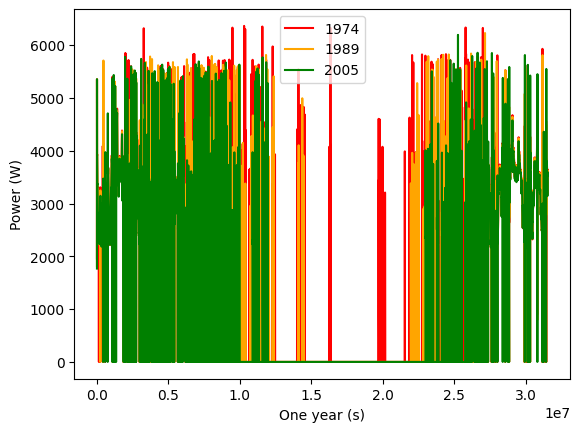

In [11]:
# On peut visualiser les courbes annuelles de puissance. On vérifie au passage qu'il n'y a pas d'aberration
years = [1974, 1989, 2005]
colors = ["red", "orange", "green"]
for k, df in enumerate([heat_profile_1974, heat_profile_1989, heat_profile_2005]):
    plt.plot(df.Puissance, label=str(years[k]), color=colors[k])
plt.xlabel("One year (s)")
plt.ylabel("Power (W)")
plt.legend();

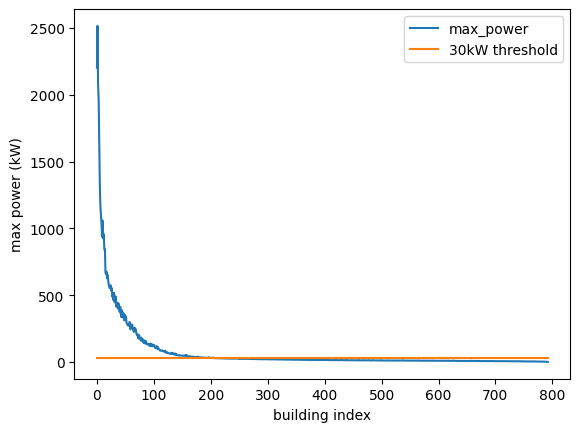

In [12]:
# Tableau du max des puissances pour chaque bâtiment
max_power = np.zeros(nb_buildings)
for k, building in enumerate(buildings):
    max_power[k] = heat_profile_coeff_tab[k] * np.max(df_tab[categorize(building)].Puissance)
plt.plot(max_power*1e-3, label="max_power")
plt.plot([30 for _ in range(nb_buildings)], label="30kW threshold")
plt.xlabel("building index")
plt.ylabel("max power (kW)")
plt.legend();

#### Filtrage des bâtiments

In [13]:
mask = np.array([power > 30e3 for power in max_power])
buildings_high = [buildings[k] for k in range(nb_buildings) if mask[k]]
nb_buildings = len(buildings_high)
print("Nombre de bâtiments dont la puissance max excède 30kW :", nb_buildings)

Nombre de bâtiments dont la puissance max excède 30kW : 209


## Deuxième observation : répartition des bâtiments les plus consommateurs et du réseau routier

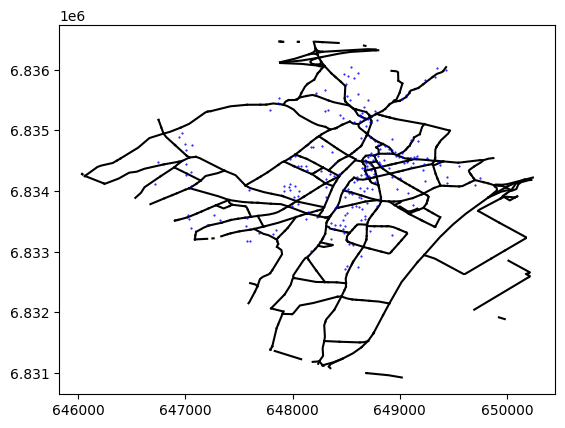

In [14]:
# Tracé des routes et positionnement des noeuds de route
for road in roads:
    # Tracé des routes
    x_ligne1, y_ligne1 = zip(*road["geometry"]["coordinates"][0])
    plt.plot(x_ligne1, y_ligne1, color="black")

# Représentation des bâtiments par des points
for building in buildings_high:
    polygon_building = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid_x, centroid_y = polygon_building.centroid.xy
    plt.plot(centroid_x, centroid_y, 'bo', markersize=0.5)

Dès lors, on a une meilleure idée des quartiers les plus propices à l'installation d'un réseau de chaleur : il s'agit de ceux qui concentrent de nombreux point bleus et ne sont pas isolés du réseau routier. Toutefois, il reste encore à trouver un moyen efficace de visualiser les consommations énergétiques des bâtiments. On pourrait utiliser une colormap, mais on peut aller plus loin.

**Remarque :** La méthode officielle présentée lors de la soutenance s'arrête ici. Les sections suivantes sont l'essai d'une méthode qui présente des résultats qui prouvent son inefficacité.

## Définition des cercles et rayons caractéristiques

La méthode du rayon caractéristique peut être utilisée pour déterminer les zones propices à l'installation d'un réseau de chaleur. Elle consiste à définir pour tout bâtiment un rayon $R$ comme :
$$
R = \frac{Q}{\lambda}
$$
où $Q$ est la demande en chaleur annuelle du bâtiment et $\lambda = 1.5MWh/m/an$ est une constante de densité linéique annuelle de chaleur. Il s'agit de la densité minimale pour un réseau de chaleur pour que l'Etat français subventionne sa construction. On dira qu'un réseau avec une telle densité est **économiquement viable**.

Ainsi, ce rayon correspond physiquement à la longueur maximale de tuyaux que l'on peut ajouter au réseau depuis le bâtiment en question afin de conserver un réseau économiquement viable.

Il est donc intéressant d'observer sur une carte comment s'intersectionnent les différents cercles caractéristiques (qui sont donc définis comme les cercles centrés sur les bâtiments et de rayons égaux aux rayons caractéristiques desdits bâtiments).

In [15]:
# Calcul des rayons caractéristiques 

lambda_ = 1.5e3 # kWh/m/an
radii = heat_demands / lambda_
radii_high = radii[:int(nb_buildings*0.1)]

## Troisième observation : les rayons caractéristiques

Par curiosité, nous commençons par afficher la carte avec les rayons caractéristiques de tous les bâtiments sur une même carte.

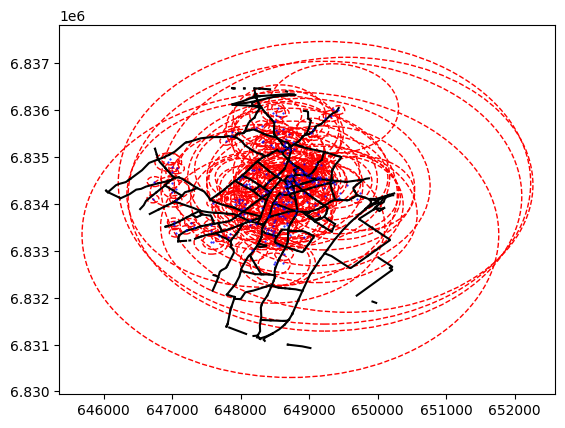

In [16]:
# Tracé des routes et positionnement des noeuds de route
for road in roads:
    # Tracé des routes
    x_ligne1, y_ligne1 = zip(*road["geometry"]["coordinates"][0])
    plt.plot(x_ligne1, y_ligne1, color="black")

# Représentation des bâtiments par des points
for k, building in enumerate(buildings_high):
    polygon_building = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid_x, centroid_y = polygon_building.centroid.xy
    plt.plot(centroid_x, centroid_y, 'bo', markersize=0.5)
    # Tracé du cercle caractéristique
    circle = plt.Circle((centroid_x, centroid_y), radii[k] + polygon_batiment.length, edgecolor='r', facecolor='none', linestyle='--', linewidth=1)
    plt.gca().add_patch(circle)

**Remarque :** en réalité, il ne s'agit pas vraiment de cercles puisqu'il faut prendre en compte la géométrie des bâtiments qui est ici négligée. En effet, les cercles sont centrés sur les barycentres des bâtiments. Bien sûr, cela sera pris en compte dans l'algorithme qui sera développé plus tard. On corrige cela ici approximativement en ajoutant au rayon caractéristique la longueur du bâtiment.

On constate des valeurs très grandes de rayons.

Une idée pour identifier les groupes de bâtiments intéressants serait de réaliser un clustering des bâtiments en considérant que deux bâtiments appartiennent à la même classe si et seulement si leurs cercles caractéristiques se recoupent. Cependant, ici, il est clair qu'il n'y a qu'un seul groupe de bâtiments en raison de certains possédant un rayon gigantesque. Cette idée n'est donc pas efficace pour aider au choix d'une zone à privilégier pour installer un réseau de chaleur.

On peut également visualiser la même carte en ne conservant que les n bâtiments les plus consommateurs.

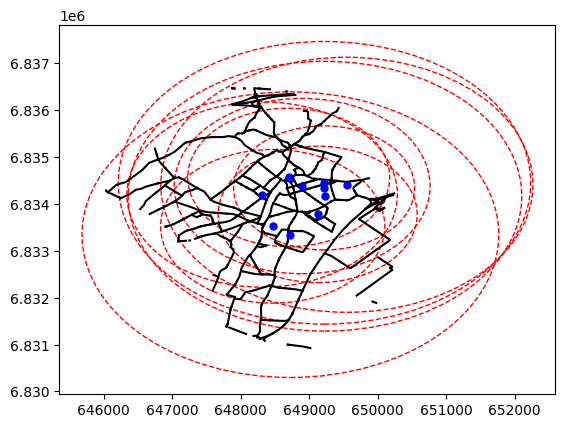

In [17]:
# Nombre de bâtiments que l'on affiche
n = 20

# Tracé des routes et positionnement des noeuds de route
for road in roads:
    # Tracé des routes
    x_ligne1, y_ligne1 = zip(*road["geometry"]["coordinates"][0])
    plt.plot(x_ligne1, y_ligne1, color="black")

# Représentation des bâtiments par des points
for k, building in enumerate(buildings_high[:10]):
    polygon_building = shape(building["geometry"])
    # Coordonnées du centre du bâtiment
    centroid_x, centroid_y = polygon_building.centroid.xy
    plt.plot(centroid_x, centroid_y, 'bo', markersize=5)
    # Tracé du cercle caractéristique
    circle = plt.Circle((centroid_x, centroid_y), radii_high[k] + polygon_batiment.length, edgecolor='r', facecolor='none', linestyle='--', linewidth=1)
    plt.gca().add_patch(circle)

Dans ce cas, les cercles caractéristiques nous donnent les informations sur la viabilité économique de raccorder les bâtiments les plus consommateurs de la ville. Cependant, il faut se méfier du fait que les cercles ne prennent pas en compte la réalité des routes. En effet, lorsque l'on connecte deux bâtiments, il faut installer les tuyaux en suivant les routes et non en ligne droite. Il faut donc observer minutieusement les détours causés par les routes afin de choisir la zone la plus pertinente pour l'installation d'un réseau de chaleur urbain.